# Tutorial: Getting your first bias corrections with bmorph
This notebook demonstrates how to setup data for and bias correct it through **bmorph**, containing the same information as the [tutorial](bmorph_tutorial.rst) page.

## Import Packages and Load Data
We will be using numpy, xarray, and pandas in this example notebook.
Note: numpy can imported directly intsead of using magic, ``%pylab inline`` if desired. More on Built-in magic commands can be found [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [1]:
%pylab inline
import xarray as xr
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


We will mainly deal with ``bmorph.core.workflows``, our primary organizing script, but will also use ``bmorph.core.mizuroute_utils`` to pre-process your data for bmorph.

In [2]:
import bmorph
from bmorph.util import mizuroute_utils as mizutil

Setting up a client for parallelism can help speed up the process
of bias correction immensely, espeically if you are working with large numbers of
watersheds. Calibrating which meteorological variable you want to condition to can take
some time, so parralelism is recommended in especially the initial uses of ``bmorph``.

In [3]:
from dask.distributed import Client, progress

In case you are just copying this over, the client is only set up with
one thread and one worker to prevent accidentally overburdening any
machine this is running on. If you actually want to use parallelism, 
make sure to change this!

In [4]:
client = Client(threads_per_worker=1, n_workers=1) #Increase for parallel power!!!

Next you provide the gauge site names and their respective river segment identification
numbers, or ``site``'s and ``seg``'s. This will be used throughout to ensure the data does
not get mismatched.

We will use the format:
`site_to_seg = { site_0_name : site_0_seg, ..., site_n_name, site_n_seg}`

In [5]:
site_to_seg = {'KEE' : 4175, 'KAC' : 4171, 'EASW': 4170, 
                   'CLE' : 4164, 'YUMW': 4162, 'BUM' : 5231,
                   'AMRW': 5228,  'CLFW': 5224,  'RIM' : 5240,
                   'NACW': 5222, 'UMTW': 4139,  'AUGW': 594,  
                   'PARW': 588,   'YGVW': 584,   'KIOW': 581}

Since it is nice to be able to access the data you just filled out without much struggle, here we create
some other useful forms of these gauge site mappings for later use.

In [6]:
seg_to_site = {seg: site for site, seg in site_to_seg.items()}
ref_sites = list(site_to_seg.keys())
ref_segs = list(site_to_seg.values())    

Next we load in topographical data (topo), meterological data (met), 
uncorrected flows (raw), and reference flows (ref). Note that some
fields have placeholder names that you should update before running.
If some data is not accessible in a single function call, be sure to collapse
it into a single file first before loading them. File designation calls assume
this code is in a folder seperate from the data, but that this code's containing
folder is at the same heirarchy as the folders containing the data. A description
of how your project directory is expected to be set up can be found in ``data.rst``.

In [7]:
basin_topo = xr.open_dataset('../topologies/yakima_huc12_topology.nc').load()

Sometimes meteorological data may only be available for a larger region
or watershed than anlayzing, so the following data will be described under such
an assumption.
    
Here we load in some example meteorological data: daily minimum temperature (tmin), seasonal precipitation (prec),
and daily maximum temperature (tmax). You can use similar or completely different data, just note naming should be universally updated and unused names should be deleted or commented out completely.

In [8]:
watershed_met = xr.open_dataset('../input/tmin.nc').load()
watershed_met['seasonal_precip'] = xr.open_dataset('../input/prec.nc')['prec'].load().rolling(time=30, min_periods=1).sum()
watershed_met['tmax'] = xr.open_dataset('../input/tmax.nc')['tmax'].load()

Hydrualic response units (hru's) are the typical coordinate for meteorologic data. Later, mizuroute_utils
will take care of mapping these hru's to seg's.

In [9]:
watershed_met['hru'] = (watershed_met['hru'] - 1.7e7).astype(np.int32)

And last not be certainly not least, we need the flows themselves! ``bmorph`` is designed to bias 
correct simulated streamflow as modeled by [mizuroute](https://mizuroute.readthedocs.io/en/latest/). As a result, loading
up the raw flows involves combining a number of flow netcdf files, hence the ``open_mfdataset``.

In [10]:
watershed_raw = xr.open_mfdataset('../input/first_route*.nc')[['IRFroutedRunoff', 'dlayRunoff', 'reachID']].load()
watershed_raw['seg'] = watershed_raw.isel(time=0)['reachID'].astype(np.int32)
watershed_ref = xr.open_dataset('../input/nrni_reference_flows.nc').load().rename({'outlet':'site'})[['seg', 'seg_id', 'reference_flow']]

/pool0/home/steinjao/.conda/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/pool0/home/steinjao/.conda/envs/project/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In order to select data for the basin of analysis from the larger watershed, we 
need the topology of the larger watershed as well.

In [11]:
watershed_topo = xr.open_dataset('../topologies/columbia_huc12_topology.nc').load()
watershed_topo = watershed_topo.where(watershed_topo['hru'] < 1.79e7, drop=True)

Here we clean up a few naming conventions to get everything on the same page in accordance with ``data.rst``.

In [12]:
if 'hru_id2' in basin_topo:
    basin_topo['hru'] = basin_topo['hru_id2']
if 'seg_id' in basin_topo:
    basin_topo['seg'] = basin_topo['seg_id']

## Convert ``mizuroute`` formatting to ``bmorph`` formatting

``mizuroute_utils`` is our utility script that will handle converting
Mizuroute outputs to what we need for ``bmorph``. For more information
on what ``mizuroute_utils`` does specifically and how to change its 
parameters, check out ``data.rst``.

Here we pull out coordinate data from the ovearching watershed
for the specific basin we want to analyze.

In [13]:
basin_ref = watershed_ref.sel(site=[r for r in ref_sites])

for site, seg in site_to_seg.items():
    if site in basin_ref['site']:
        basin_ref['seg'].loc[{'site': site}] = seg

Now we pass it off to ``mizuroute_to_blendmorph``, the primary utility 
function for automating ``bmorph`` pre-procesing.

In [14]:
basin_met_seg = mizutil.mizuroute_to_blendmorph(
    basin_topo, watershed_raw.copy(), basin_ref, watershed_met, 
    fill_method='r2').ffill(dim='seg')

## Apply ``bmorph`` bias correction

We are almost to actually bias correcting! First we need to specify some parameters 
for correction. Returning to these parameters can help fine tune your bias 
corrections to the basin you are analyzing.

In this notebook, all four variations of ``bmorph`` are demonstrated: 
IBC_U, IBC_C, SCBC_U, and SCBC_C, as described in ``bias_correction.rst``.

The ``train_window`` is what we will use to train the bias correction
model. This is the time range that is representative of the
basin's expected behavior that ``bmorph`` should mirror.

The ``bmorph_window`` is when ``bmorph`` should be applied to the series for
bias correction.

Lastly the ``reference_window`` is when the reference flows should be used to 
smooth the bias corrected flows. This is recommended to be set as equivalent to the
``train_window``.

In [15]:
train_window = pd.date_range('1981-01-01', '1990-12-30')[[0, -1]]
bmorph_window = pd.date_range('1991-01-01', '2005-12-30')[[0, -1]]
reference_window = train_window

``interval`` is the length of``bmorph``'s application intervals, 
typically a factor of years to preserve hydrologic 
relationships. Note that for ``pandas.DateOffset``, 'year' and 'years' 
are different and an 's' should always be included here for ``bmorph``
to run properly, even for a single year.

``overlap`` describes how many days the bias correction cumulative distribtuion function
windows should overlap in total with each other. ``overlap`` is evenly distributed before
and after this window. This is used to reduce discontinuities between application periods.

``condition_var`` names the variable to use in conditioning, such as maximum
temperature (tmax), seasonal precipitation (seasonal_precip), or daily
minimum temperature (tmin). At this time, only one conditioning
meteorological variable can be used per ``bmorph`` execution. In this example,
``tmax`` and ``seasonal_precip`` have been commented out to select ``tmin`` as
the conditioning variable. If you wish to change this, be sure to either change
which variables are commented out or change the value of ``condition_var`` itself.

In [16]:
interval = pd.DateOffset(years=1)
overlap = 90

#condition_var = 'tmax'
#condition_var = 'seasonal_precip'
condition_var = 'tmin'

Here we name some configuration parameters for ``bmorph``'s conditional and univariate
bias correction metods, respectively. If you have been following along with the
rest of the naming conventions in this section so far, then there is
nothing you need to change here.

In [17]:
conditonal_config = {
    'train_window': train_window,
    'bmorph_window': bmorph_window,
    'reference_window': reference_window,
    'bmorph_interval': interval,
    'bmorph_overlap': overlap,
    'condition_var': condition_var
}

univariate_config = {
    'train_window': train_window,
    'bmorph_window': bmorph_window,
    'reference_window': reference_window,
    'bmorph_interval': interval,
    'bmorph_overlap': overlap,
}

You made it! Now we can actually bias correction with ``bmorph``! Depending
on the size of your data and use of parallelism or not, the following cells
will likely take the longest to run, so make certain everything else looks
good to you before running it.

First off we run the Independent Bias Corrections, which is completely contained
in the cell below. If you are interested in ``bmorph``'s spatial consitency and conditioing
bias corrections, this cell is not it. However, it can be useful to run at least once
so you have a baseline method to compare to as you fine tune variables.

Here we run through each of the gauge sites and correct them 
individually. Since independent bias correction can only be performed
at locations with reference data, corrections are only performed at
the gauge sites here. If you have not changed any naming conventions
so far, then there is nothing that you need to alter here, it has all already
been extracted above for your convenience.

In [18]:
ibc_u_flows = {}
ibc_u_mults = {}
ibc_c_flows = {}
ibc_c_mults = {}

raw_flows = {}
ref_flows = {}

for site, seg in site_to_seg.items():
    raw_ts = basin_met_seg.sel(seg=seg)['IRFroutedRunoff'].to_series()
    train_ts = basin_met_seg.sel(seg=seg)['IRFroutedRunoff'].to_series()
    obs_ts = basin_met_seg.sel(seg=seg)['up_ref_flow'].to_series()
    cond_var = basin_met_seg.sel(seg=seg)[f'up_{condition_var}'].to_series()
    ref_flows[site] = obs_ts
    raw_flows[site] = raw_ts

    ## IBC_U (Independent Bias Correction: Univariate)
    ibc_u_flows[site], ibc_u_mults[site] = bmorph.workflows.apply_interval_bmorph(
        raw_ts, train_ts, obs_ts, train_window, bmorph_window, reference_window, interval, overlap)

    ## IBC_C (Independent Bias Correction: Conditioned)
    ibc_c_flows[site], ibc_c_mults[site] = bmorph.workflows.apply_interval_bmorph(
        raw_ts, train_ts, obs_ts, train_window, bmorph_window, reference_window, interval, overlap,
        raw_y=cond_var, train_y=cond_var, obs_y=cond_var)

Here you specify where ``mizuroute`` is installed on your system
and set up some variables to store total flows.

``output_prefix`` will be used to write and load files according to the
basin's name, make certain to update this with the actual name of
the basin you are analyzing so you can track where different files
are writen.

In [19]:
mizuroute_exe = '/pool0/data/andrbenn/spatially_consistent_bias_correction/multi_site_workflow/mizuroute' # mizuroute designation

unconditioned_seg_totals = {}
conditioned_seg_totals = {}
unconditioned_site_totals = {}
conditioned_site_totals = {}
output_prefix = "Yakima" # basin name

Now we use ``run_parallel_scbc`` to do the rest! This may take a while ...

In [20]:
unconditioned_seg_totals = bmorph.workflows.run_parallel_scbc(basin_met_seg, client, output_prefix, mizuroute_exe, univariate_config)
conditioned_seg_totals = bmorph.workflows.run_parallel_scbc(basin_met_seg, client, output_prefix, mizuroute_exe, conditonal_config)
# Here we select out our rerouted gauge site modeled flows.
for site, seg in site_to_seg.items():
    unconditioned_site_totals[site] = unconditioned_seg_totals['IRFroutedRunoff'].sel(seg=seg).to_series()
    conditioned_site_totals[site] = conditioned_seg_totals['IRFroutedRunoff'].sel(seg=seg).to_series()

/pool0/home/steinjao/.conda/envs/project/lib/python3.7/site-packages/distributed/worker.py:3285: UserWarning: Large object of size 2.28 MB detected in task graph: 
  (<xarray.Dataset>
Dimensions:               (time: ... . 0.9181 1.31,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
/pool0/data/steinjao/bmorph/bmorph/core/workflows.py:680: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  region_totals = xr.open_mfdataset(f'{mizuroute_config["output_dir"]}{region.lower()}_{scbc_type}_scbc*').load()
/p

Lastly we combine all the data into a singular xarray.Dataset, putting a nice little bow
on your basin's analysis. If you did not run all parts of bmoprh, make certain to comment
out those lines below.

In [21]:
scbc_c = bmorph.workflows.bmorph_to_dataarray(conditioned_site_totals, 'scbc_c')
basin_analysis = xr.Dataset(coords={'site': list(site_to_seg.keys()), 'time': scbc_c['time']})
basin_analysis['scbc_c'] = scbc_c
basin_analysis['scbc_u'] = bmorph.workflows.bmorph_to_dataarray(unconditioned_site_totals, 'scbc_u')
basin_analysis['ibc_u'] = bmorph.workflows.bmorph_to_dataarray(ibc_u_flows, 'ibc_u')
basin_analysis['ibc_c'] = bmorph.workflows.bmorph_to_dataarray(ibc_c_flows, 'ibc_c')
basin_analysis['raw'] = bmorph.workflows.bmorph_to_dataarray(raw_flows, 'raw')
basin_analysis['ref'] = bmorph.workflows.bmorph_to_dataarray(ref_flows, 'ref')
basin_analysis.to_netcdf(f'../output/{output_prefix.lower()}_data_processed.nc')

/pool0/data/steinjao/bmorph/bmorph/core/workflows.py:686: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  da = xr.DataArray(np.vstack(dict_flows.values()), dims=('site', 'time'))


## Now let's take a look at our results

If you look closely, the following plots are the same ones included in [Plotting](evaluation.rst/Plotting)! Because the plotting functions expect the variable `seg`, we will need to conflate `site` and `seg` for them to properly run.

In [47]:
from bmorph.evaluation import plotting

yakima_ds = xr.open_dataset(f'../output/{output_prefix.lower()}_data_processed.nc')
yakima_ds = yakima_ds.rename({'site':'seg'})

Let's pick a few sites and colors to plot for consistency. To simplify our plots, we will only focus on `scbc_c` in the dataset we just created. The methods do allow for multiple methods to be compared at once however, so we will still need to store the singular `scbc_c` in a list.

Feel free to mess around with the parameters of any of these plots. You can plot more sites if desired, or more methods, just make certain arguments properly line up.

In [72]:
select_sites = ['KIOW','YUMW','BUM']
select_sites_2 = ['KIOW','YUMW','BUM','KEE']
bcs = ['scbc_c']
colors = ['grey', 'black', 'red']

### Scatter

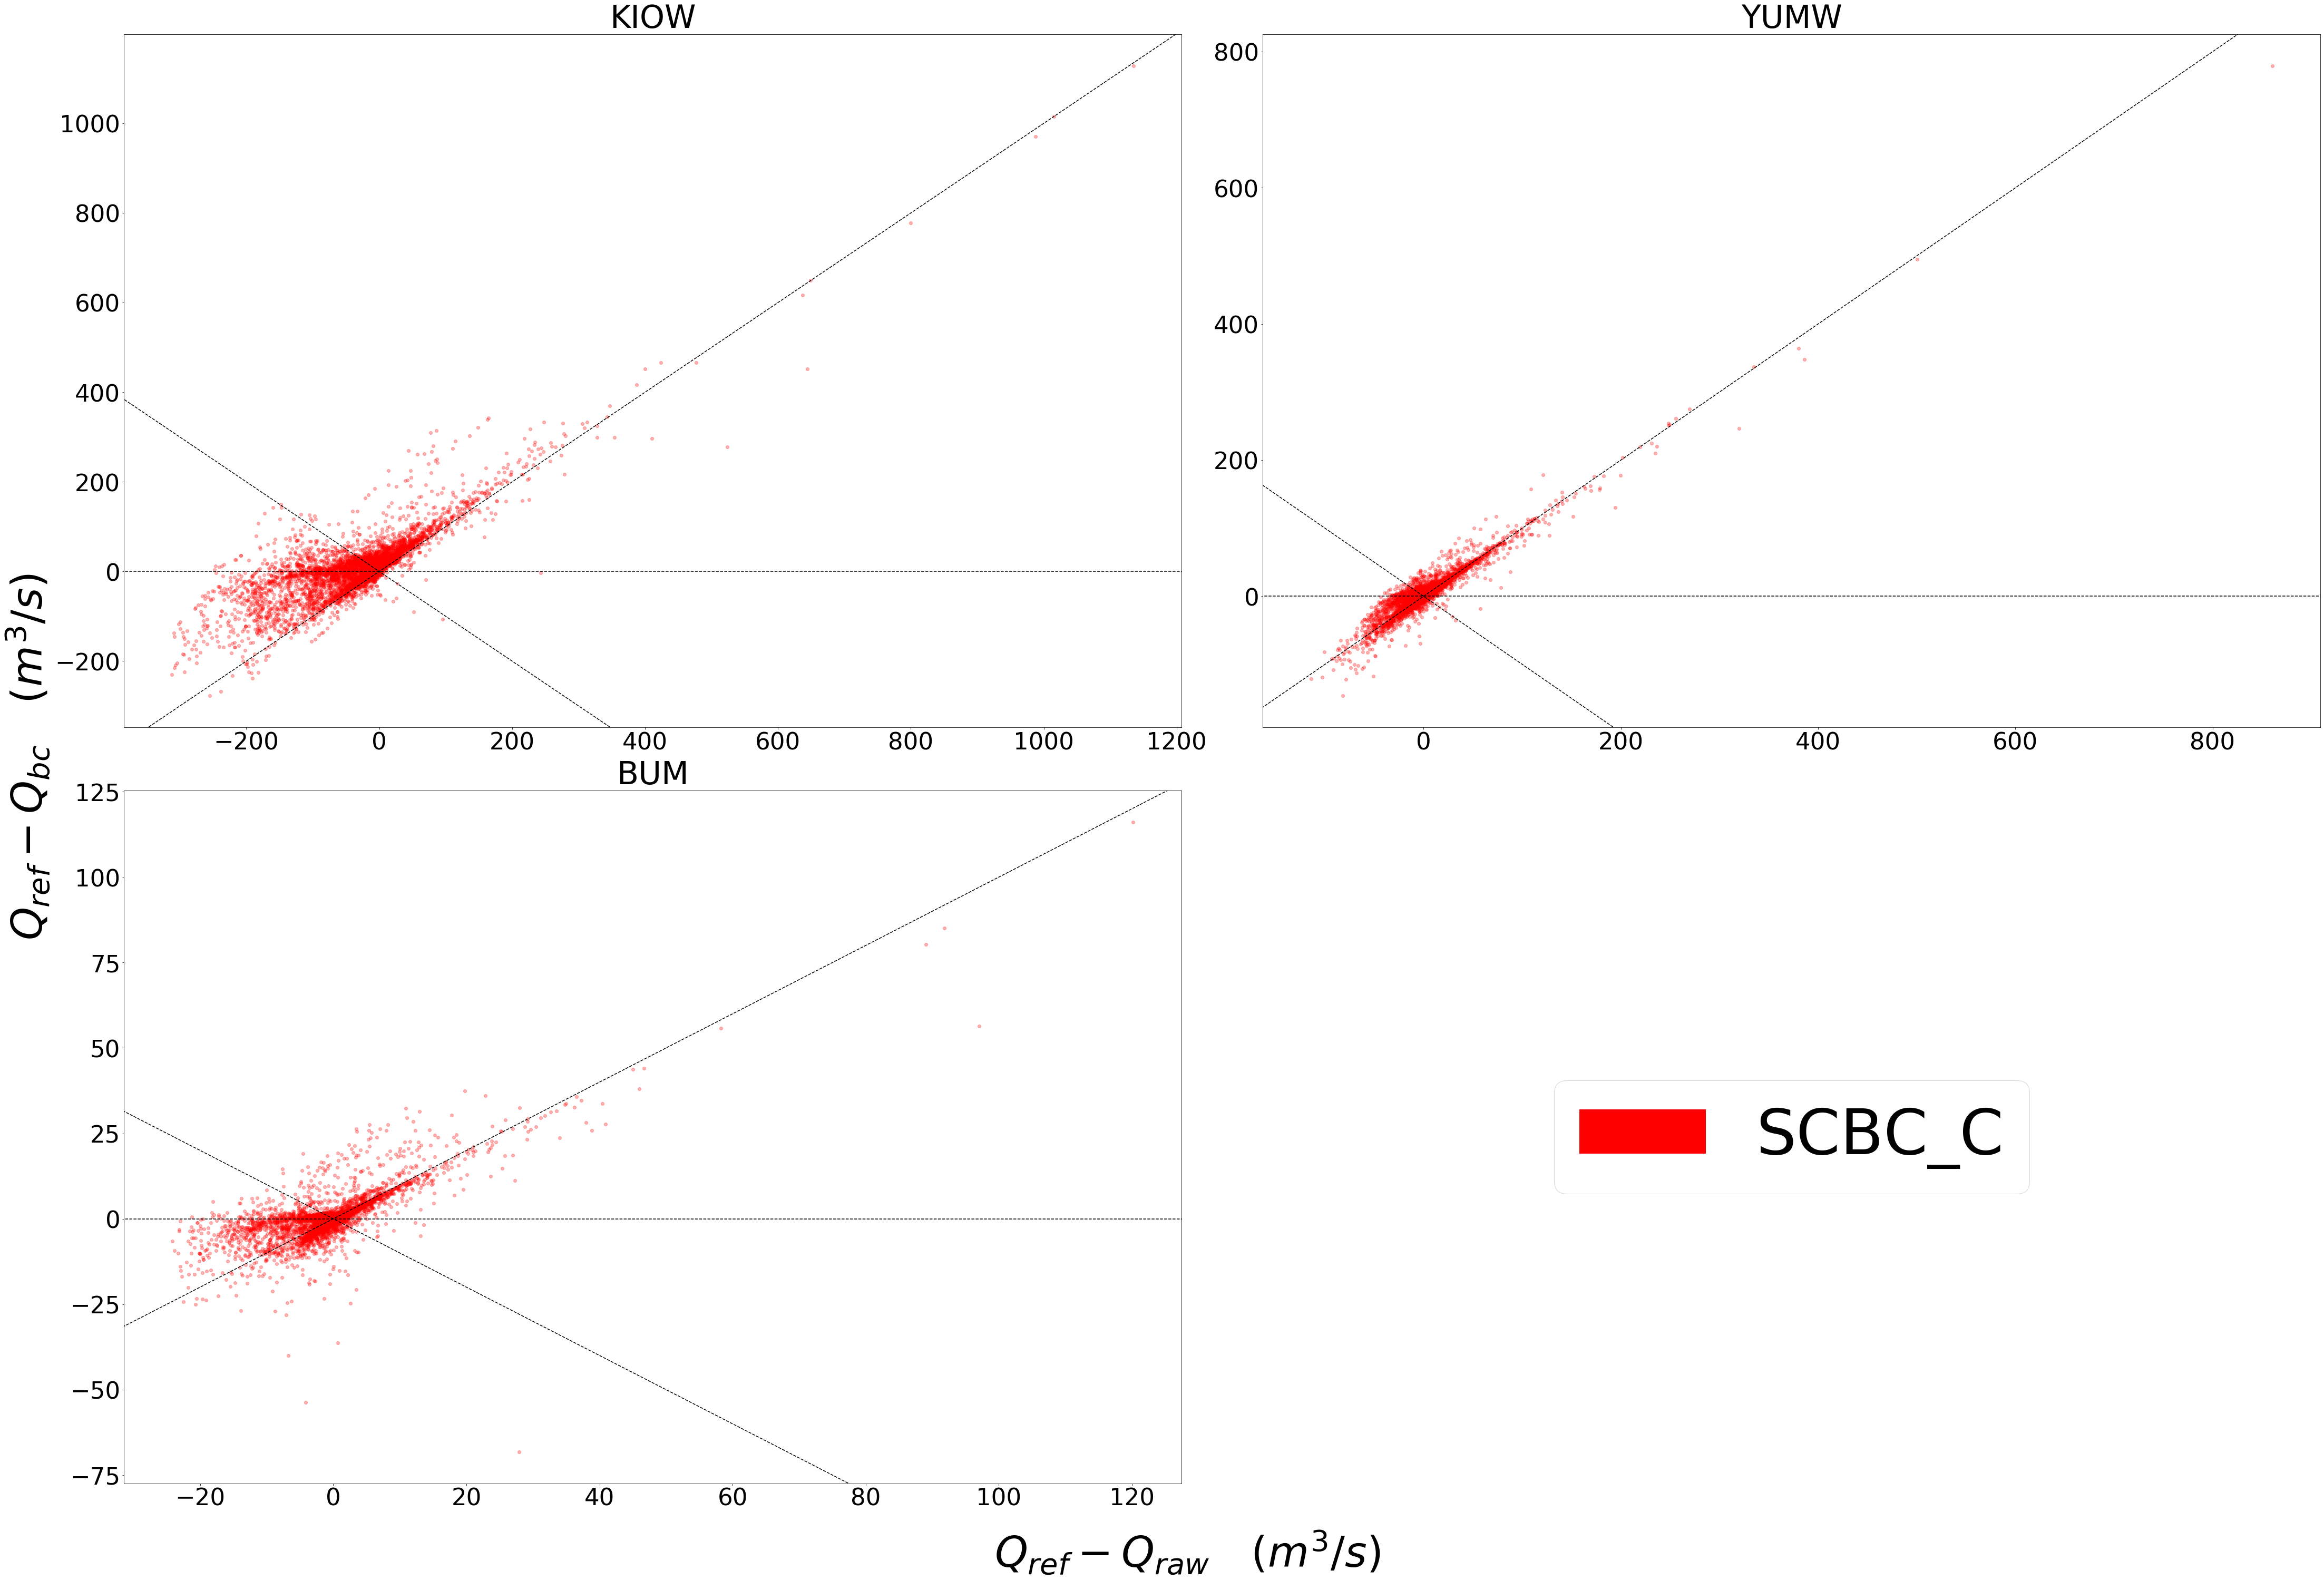

In [60]:
plotting.compare_correction_scatter(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites,
    raw_var = 'raw', 
    ref_var = 'ref', 
    bc_vars = bcs, 
    bc_names = [bc.upper() for bc in bcs],
    plot_colors = list(colors[-1]),
    pos_cone_guide = True,
    neg_cone_guide = True,
    symmetry = False,
    title = '',
    fontsize_legend = 120,
    alpha = 0.3
)

### Time Series

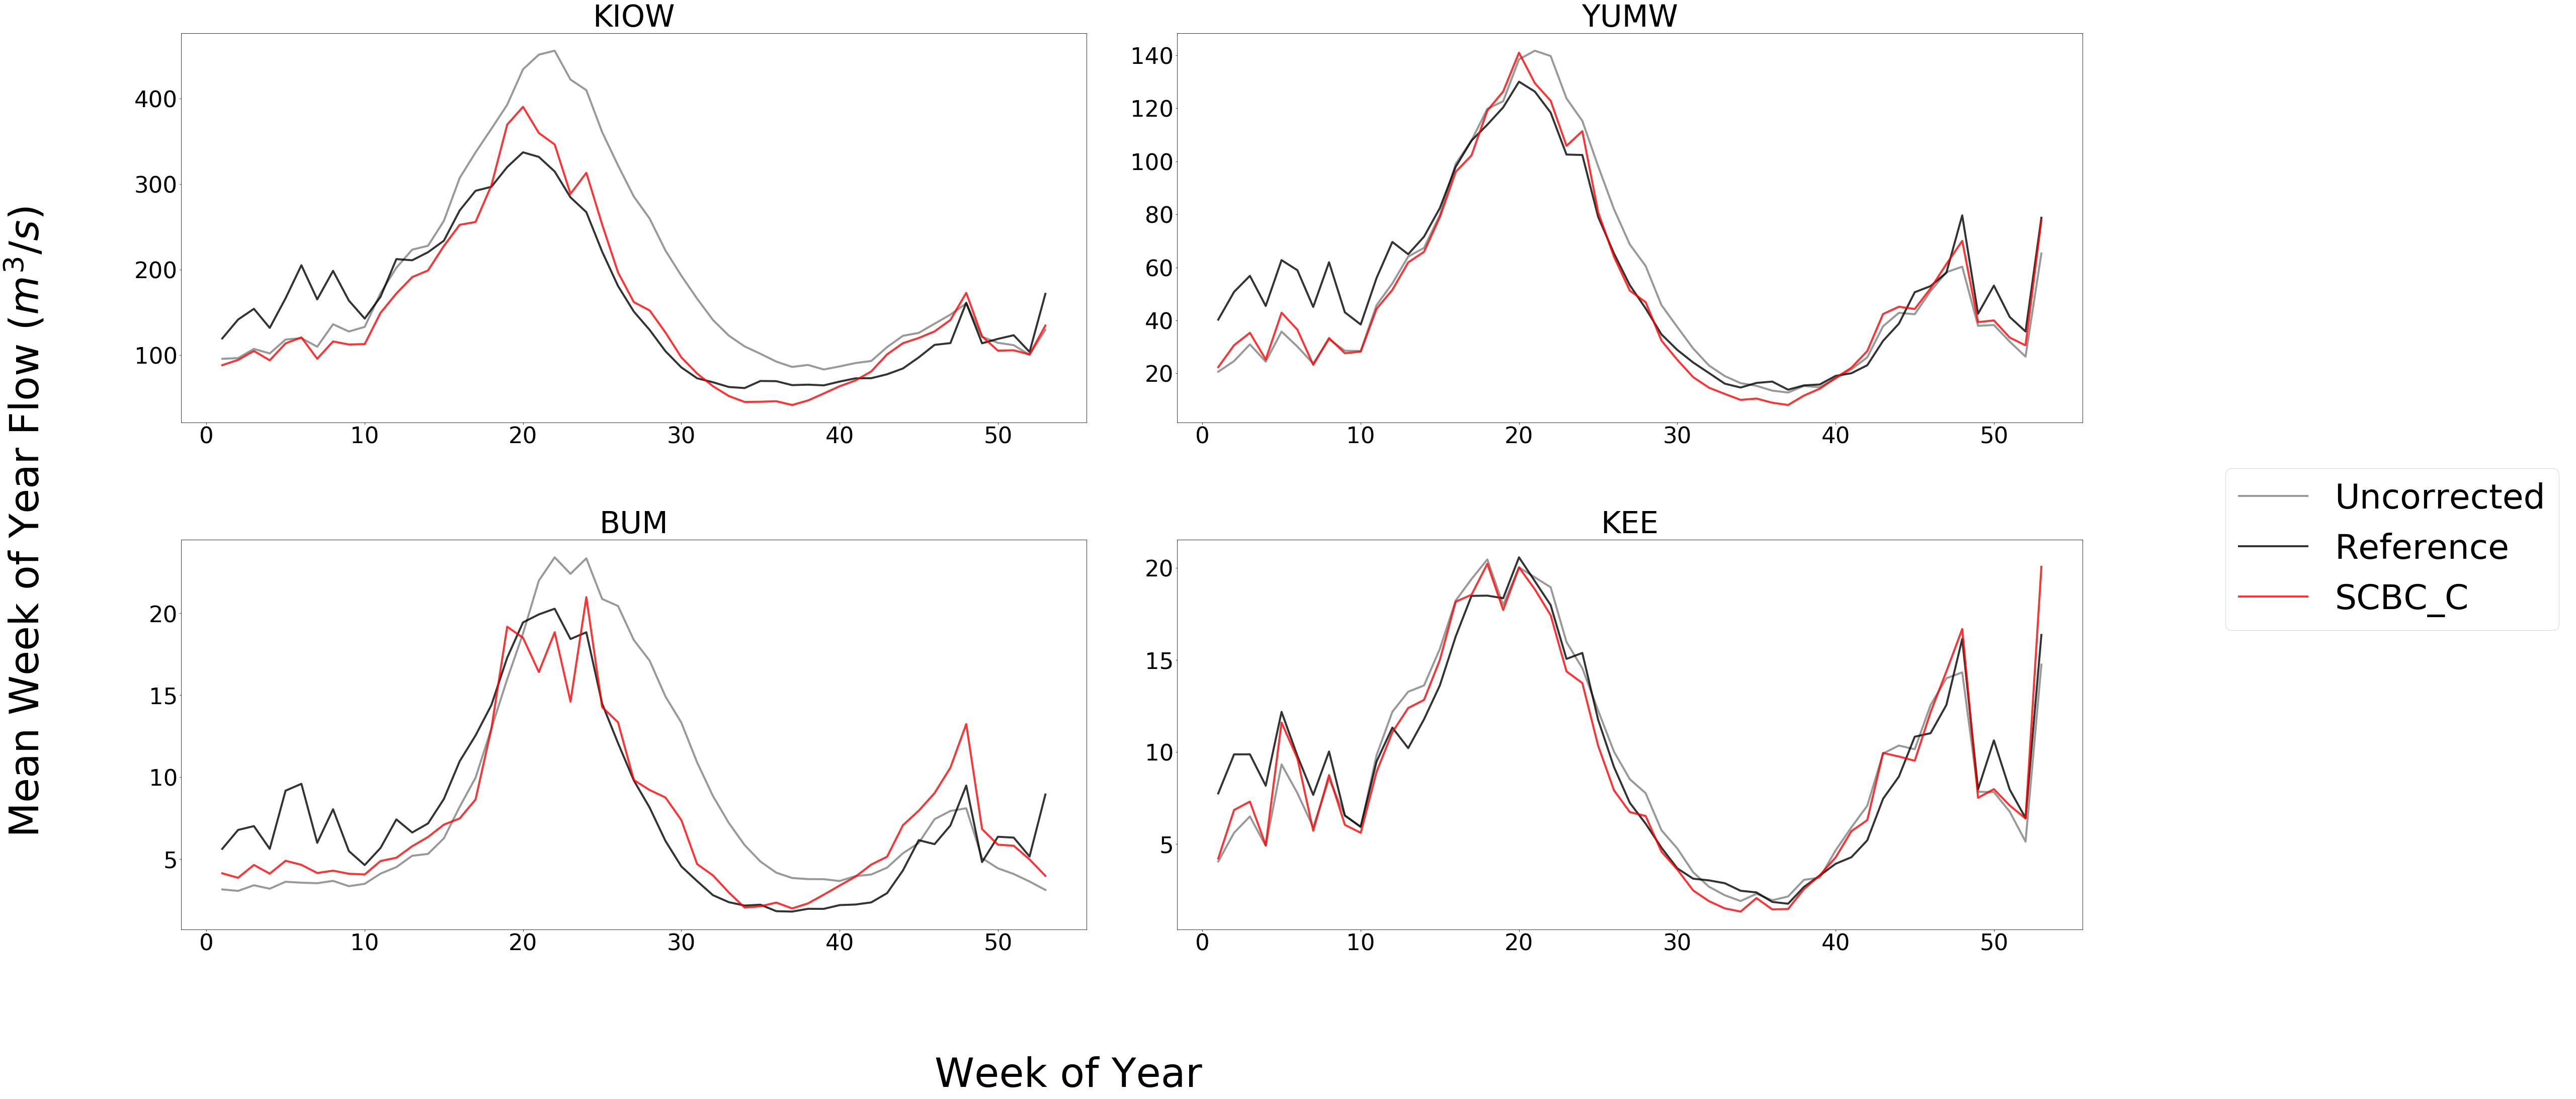

In [68]:
plotting.plot_reduced_flows(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites_2, 
    interval = 'week',
    raw_var = 'raw', raw_name = "Uncorrected",
    ref_var = 'ref', ref_name = "Reference",
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = colors
);

### Probabilitiy Distribtutions

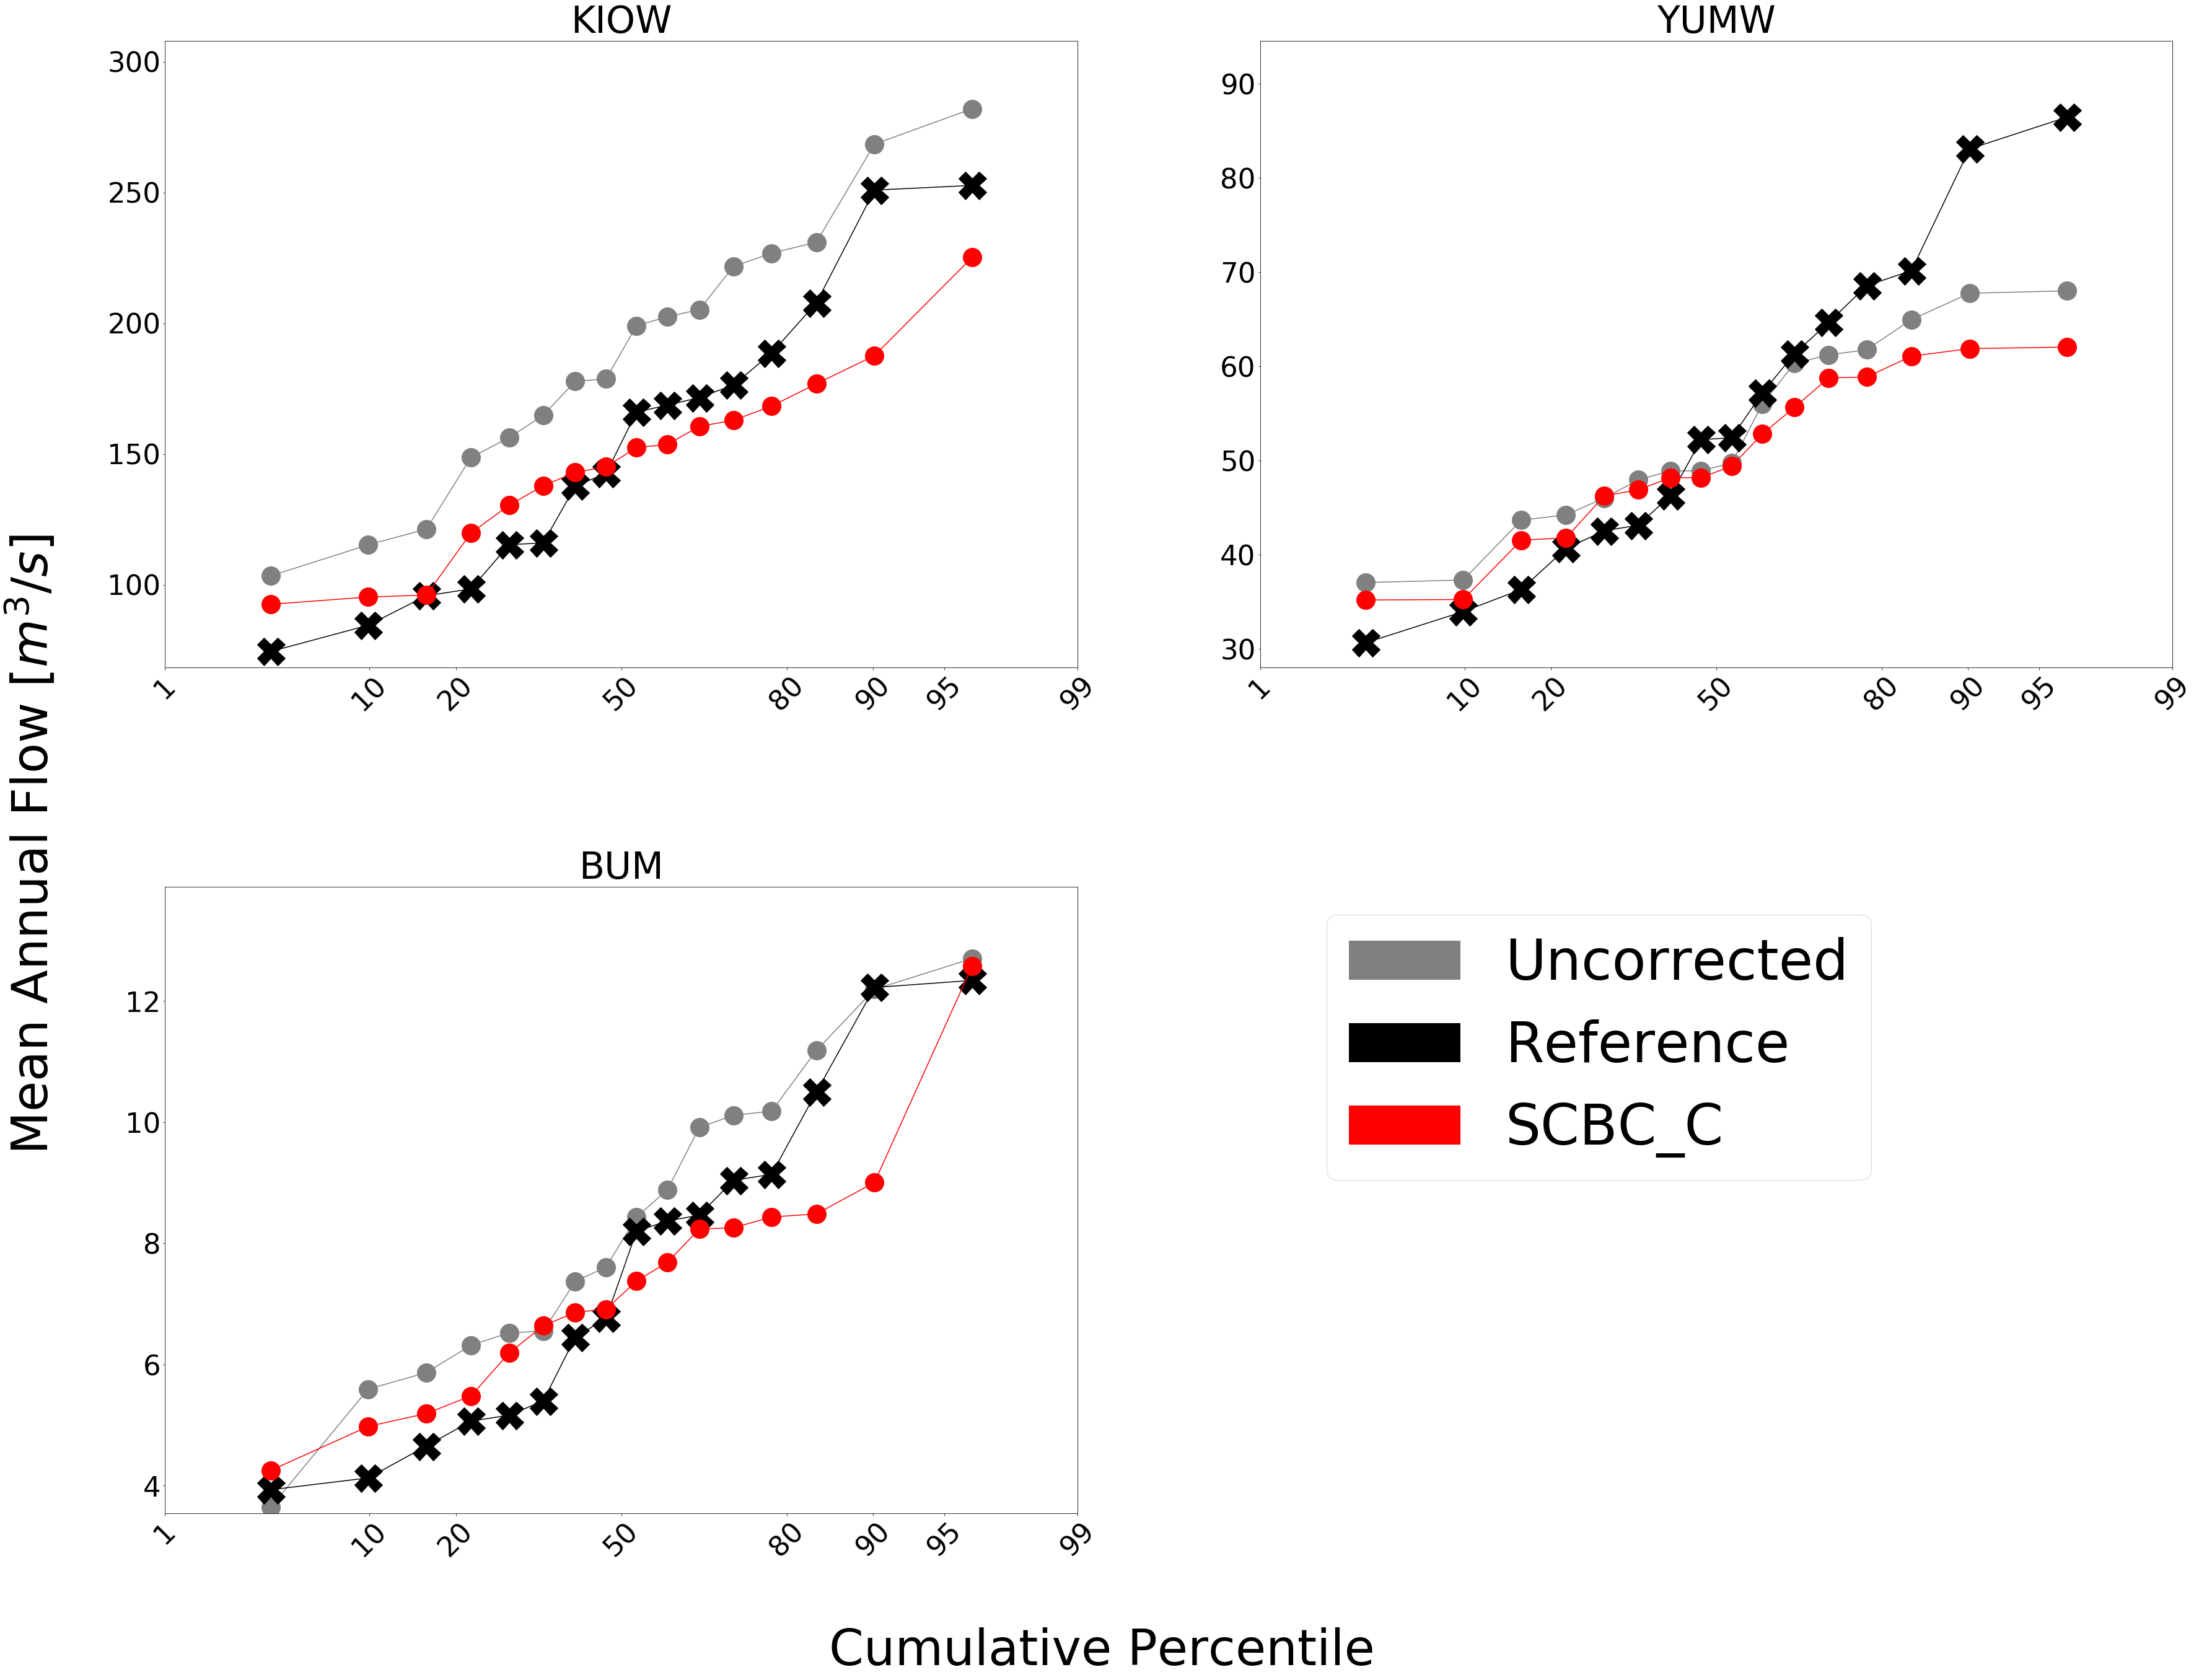

In [66]:
plotting.compare_mean_grouped_CPD(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites,
    grouper_func = plotting.calc_water_year, 
    figsize = (60,40),
    raw_var = 'raw', raw_name = 'Uncorrected',
    ref_var = 'ref', ref_name = 'Reference',
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = colors,
    linestyles = ['-','-','-'],
    markers = ['o', 'X', 'o'],
    fontsize_legend = 90,
    legend_bbox_to_anchor = (1.9,1.0)
);

### Box & Whisker

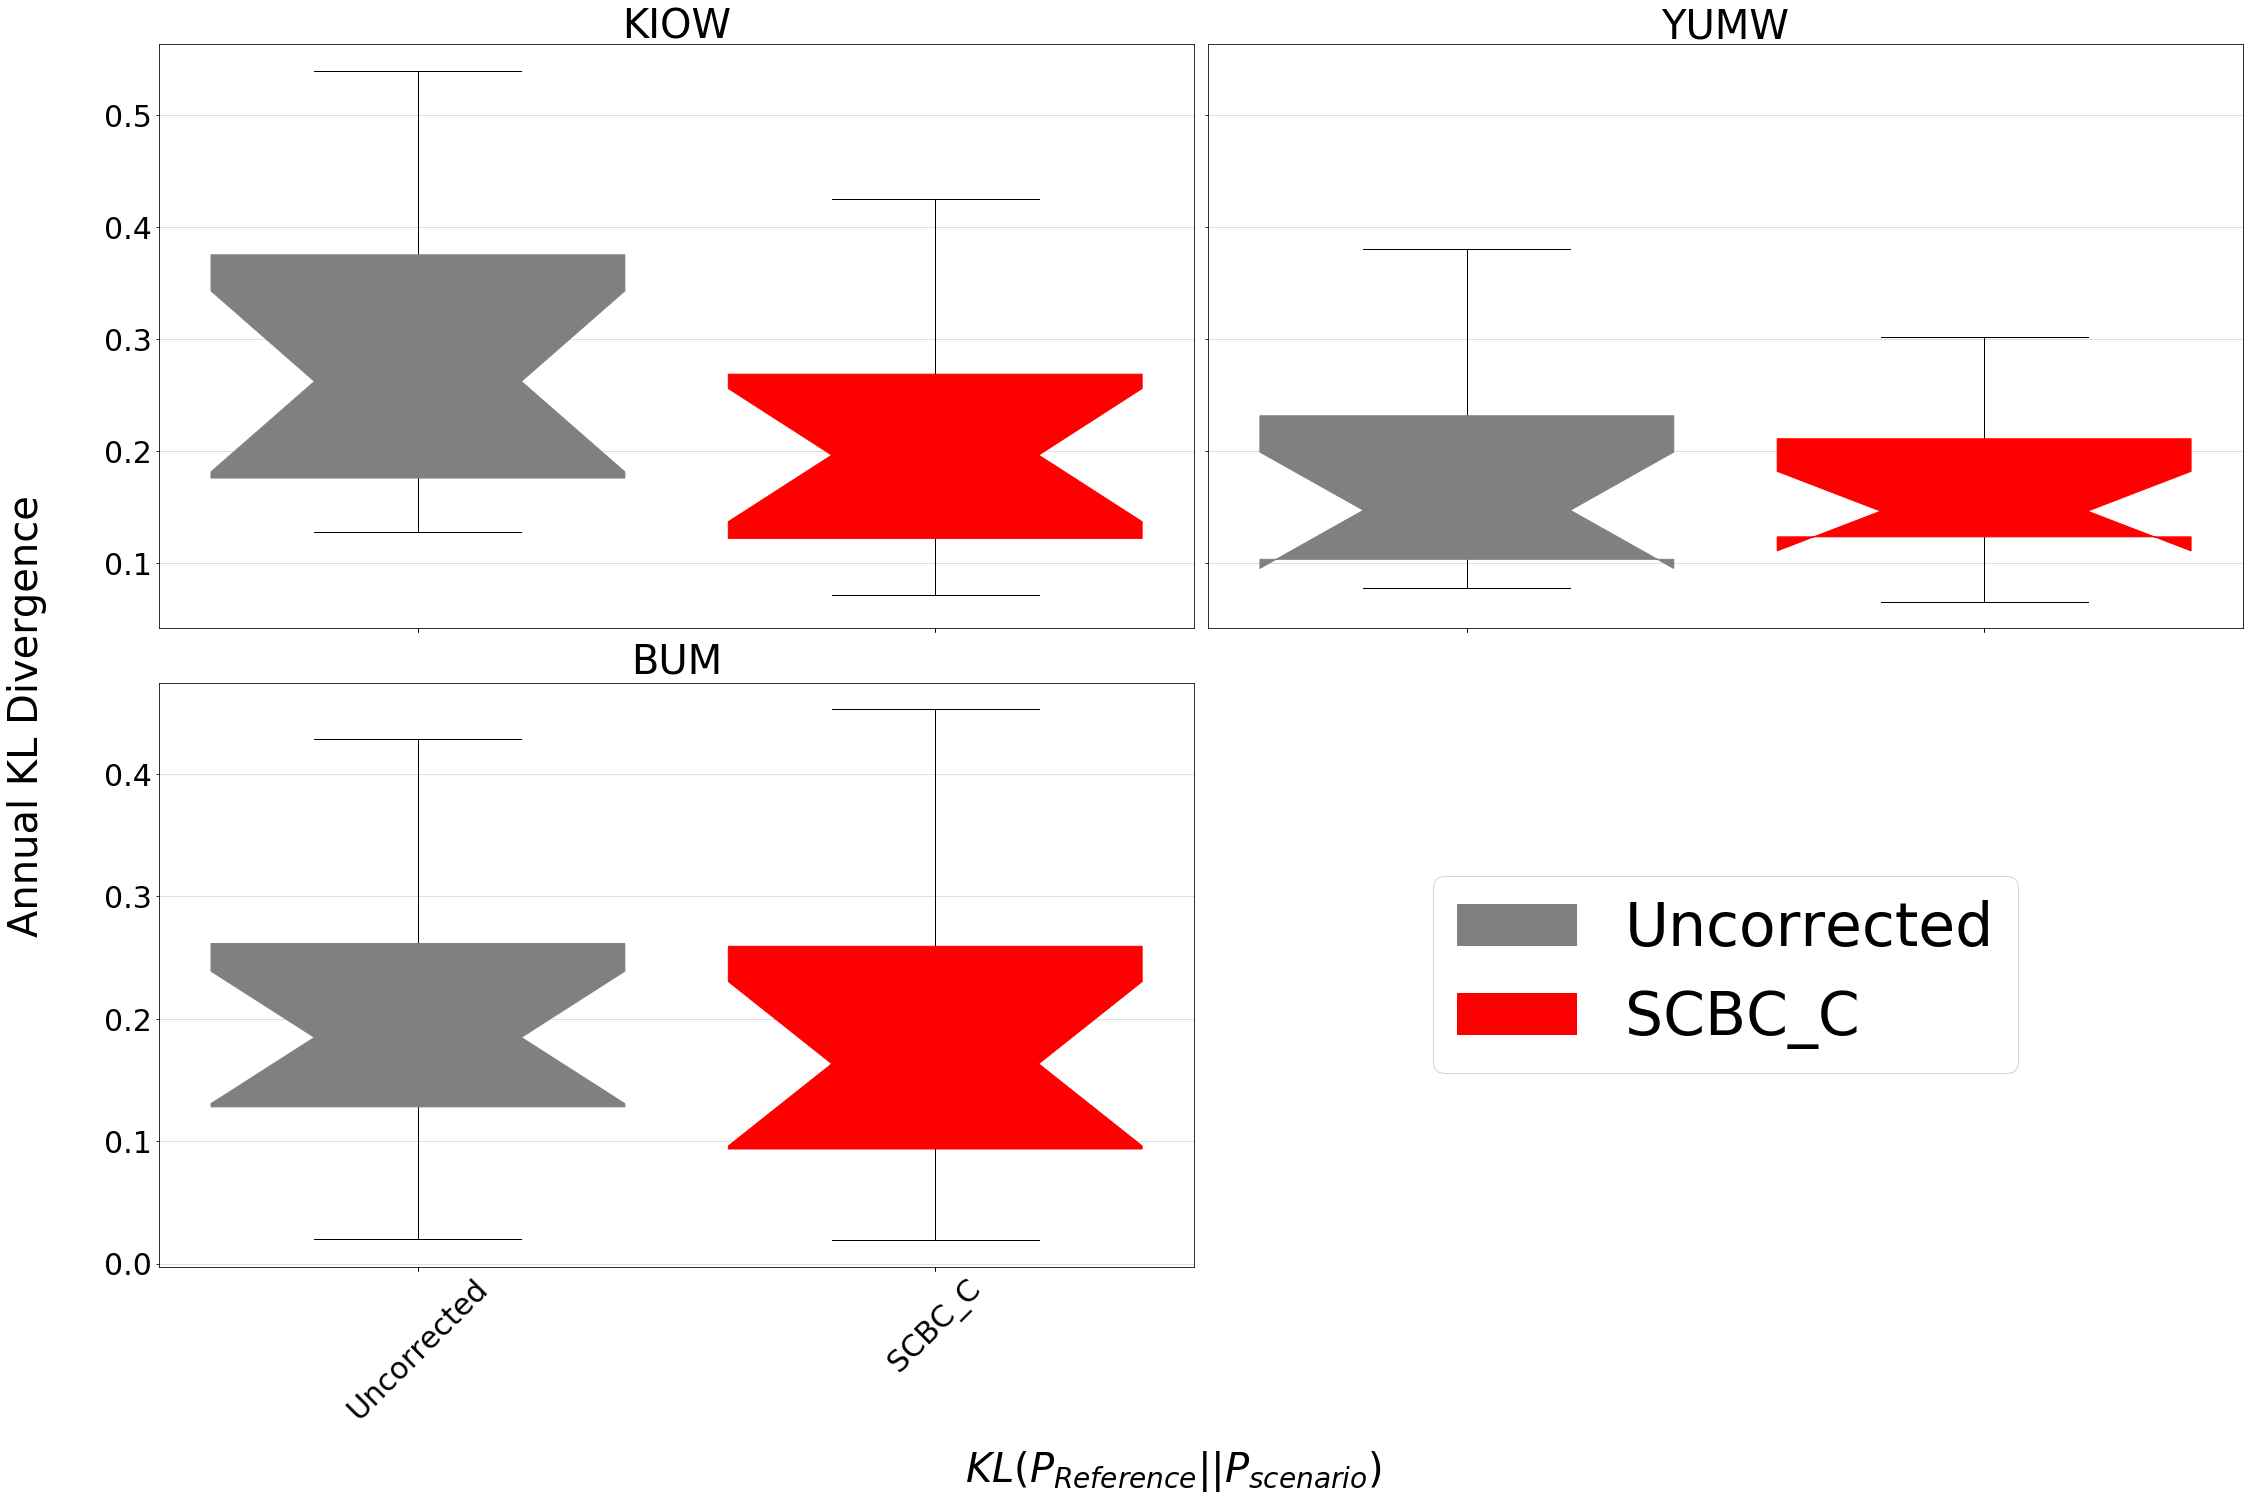

In [71]:
plotting.kl_divergence_annual_compare(
    flow_dataset= yakima_ds, 
    sites = select_sites,
    fontsize_legend = 60, title = '',
    raw_var = 'raw', raw_name = 'Uncorrected',
    ref_var = 'ref', ref_name = 'Reference',
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = ['grey','red']
);